In [1]:
%matplotlib inline

# Example plot for LFPy: Hay et al. (2011) spike waveforms
Run Hay et al. (2011) layer 5b pyramidal cell model, generating and plotting a
single action potential and corresponding extracellular potentials (spikes)


Copyright (C) 2017 Computational Neuroscience Group, NMBU.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

In [2]:
import numpy as np
import sys
from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch Hay et al. 2011 model files

In [3]:
if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    #get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

#compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')

/Users/espehage/miniforge3/envs/lfpy/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/espehage/Repositories/LFPy/examples/L5bPCmodelsEH/mod
Mod files: "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./SK_E2.mod" "./SKv3_1.mod" "./epsp.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


## Simulation parameters:

In [4]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-5,
    'tstart' : 0,
    'tstop' : 20,
    'v_init' : -60,
    'celsius': 34,
}

## Main simulation procedure, setting up extracellular electrode, cell, synapse:

In [5]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# Initialize cell instance, using the LFPy.Cell class
cell = LFPy.TemplateCell(**cellParameters)

np.random.seed(1234)
synlist = []
synidx = cell.get_rand_idx_area_norm(section=['apic', 'soma', 'dend'], nidx=10)

synapseParameters = {
    'e' : 0.,                   # reversal potential
    'syntype' : 'Exp2Syn',       # synapse type
    'tau1' : 0.1,                # synaptic time constant
    'tau2' : 2,                 # synaptic time constant
    'weight' : 0.02,            # synaptic weight
    'record_current' : True,    # record synapse current
}
for idx in synidx:
    syn = LFPy.Synapse(cell, idx=idx, **synapseParameters)
    syn.set_spike_times(np.array([10.]))
    synlist.append(syn)

cell.simulate(rec_imem=True, rec_vmem=True, rec_icap=True, rec_variables=['i_pas', 'i_cap', 'ica', 'ihcn', 'ik', 'ina'])

non-existing variable ica, section L5PCtemplate[0].dend[0].0.500000
non-existing variable ica, section L5PCtemplate[0].dend[1].0.500000
non-existing variable ica, section L5PCtemplate[0].dend[2].0.071429
non-existing variable ica, section L5PCtemplate[0].dend[2].0.214286
non-existing variable ica, section L5PCtemplate[0].dend[2].0.357143
non-existing variable ica, section L5PCtemplate[0].dend[2].0.500000
non-existing variable ica, section L5PCtemplate[0].dend[2].0.642857
non-existing variable ica, section L5PCtemplate[0].dend[2].0.785714
non-existing variable ica, section L5PCtemplate[0].dend[2].0.928571
non-existing variable ica, section L5PCtemplate[0].dend[3].0.500000
non-existing variable ica, section L5PCtemplate[0].dend[4].0.100000
non-existing variable ica, section L5PCtemplate[0].dend[4].0.300000
non-existing variable ica, section L5PCtemplate[0].dend[4].0.500000
non-existing variable ica, section L5PCtemplate[0].dend[4].0.700000
non-existing variable ica, section L5PCtemplate[

In [6]:
# convert from (mA/cm2) to (nA):
# (nA) = (mA/cm2) * (µm2) * 1E-2 (nAcm2/mAµm2)
i_nA = {key: (val.T * cell.area).T * 1E-2 for key, val in cell.rec_variables.items()}

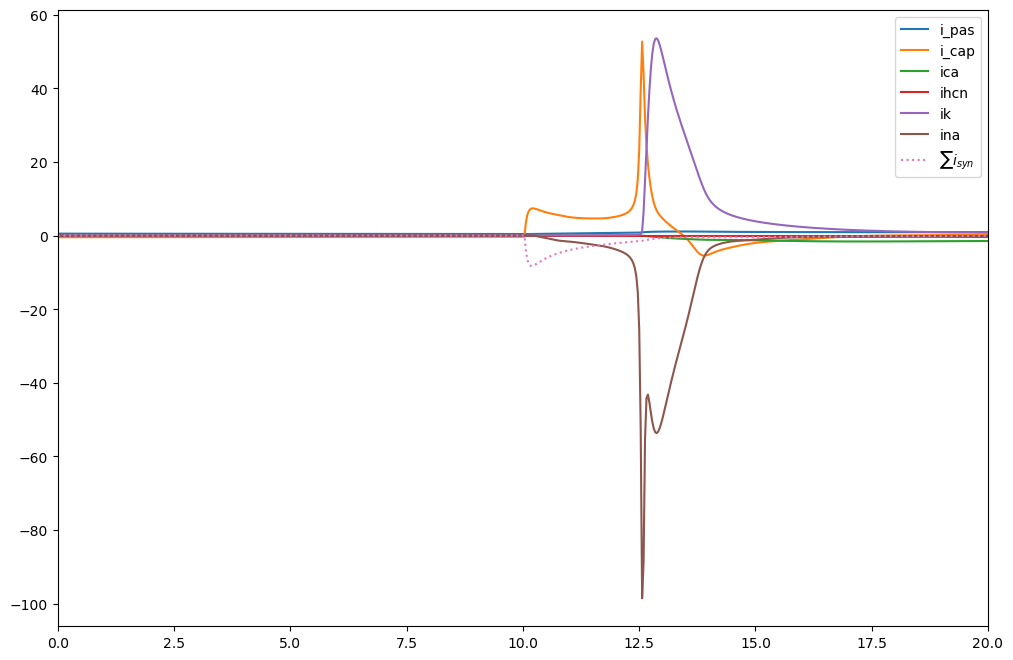

In [9]:
plt.figure(figsize=(12, 8))
for key, val in i_nA.items():
    plt.plot(cell.tvec, val.sum(axis=0), label=key)

# for i, syn in enumerate(synlist):
#     plt.plot(cell.tvec, syn.i, ':', label='syn. %d' % i)
plt.plot(cell.tvec, sum(syn.i for syn in synlist), ':', label=r'$\sum i_{syn}$')

plt.xlim(0, 20)
plt.legend()

(9.0, 20.0)

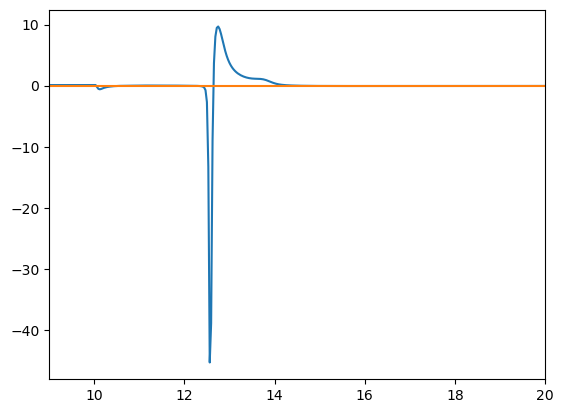

In [10]:
plt.plot(cell.tvec, sum(i_nA.values()).sum(axis=0) + sum(syn.i for syn in synlist))
plt.plot(cell.tvec, cell.imem.sum(axis=0))
plt.xlim(9., 20)

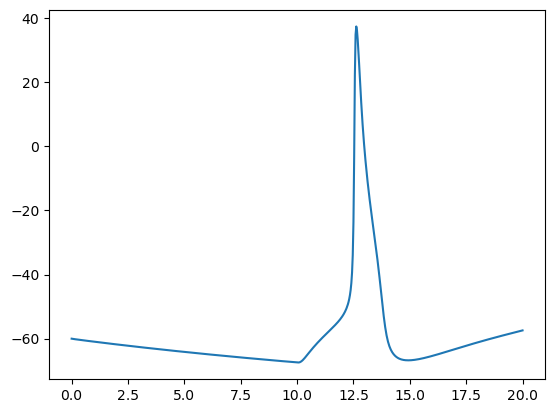

In [11]:
plt.plot(cell.tvec, cell.somav)